In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch.nn.functional as F

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer


Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [14]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [15]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, mish, batch, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)
            x = batch(x)
            x = mish(x)
            x = drop(x)
            
        return x

In [16]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, mish, batch, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = mish(x)
            x = drop(x)
            
        out = self.conv_final(x)
        return out

In [17]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [18]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [19]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = RMSELoss()
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

Training the model

In [21]:
model_path = os.path.join('../../../models/STConvS2S_Mish_Adamod' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, False, model_path, False, 5)


In [22]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 6.835147
Val Avg. Loss: 6.429854
=> Saving a new best
Train - Epoch 1, Epoch Loss: 6.423178
Val Avg. Loss: 6.432401
Train - Epoch 2, Epoch Loss: 6.396305
Val Avg. Loss: 6.414397
=> Saving a new best
Train - Epoch 3, Epoch Loss: 6.392319
Val Avg. Loss: 6.385518
=> Saving a new best
Train - Epoch 4, Epoch Loss: 6.376284
Val Avg. Loss: 6.372295
=> Saving a new best
Train - Epoch 5, Epoch Loss: 6.375553
Val Avg. Loss: 6.371879
=> Saving a new best
Train - Epoch 6, Epoch Loss: 6.363873
Val Avg. Loss: 6.359277
=> Saving a new best
Train - Epoch 7, Epoch Loss: 6.364344
Val Avg. Loss: 6.358996
=> Saving a new best
Train - Epoch 8, Epoch Loss: 6.353598
Val Avg. Loss: 6.364868
Train - Epoch 9, Epoch Loss: 6.355067
Val Avg. Loss: 6.357185
=> Saving a new best
Train - Epoch 10, Epoch Loss: 6.353324
Val Avg. Loss: 6.345678
=> Saving a new best
Train - Epoch 11, Epoch Loss: 6.355731
Val Avg. Loss: 6.355098
Train - Epoch 12, Epoch Loss: 6.342932
Val Avg. Loss: 6.344404
=>

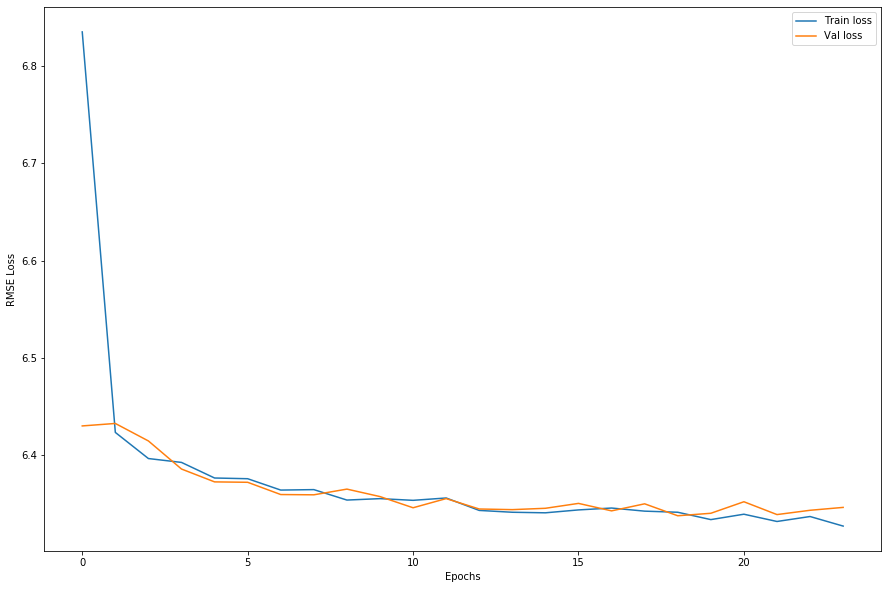

In [26]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [25]:
from utils.trainer import Tester

model, optimizer, epoch, loss = trainer.load_model()
tester = Tester(model, test_loader, criterion, optimizer, device, False, False)
test_loss = tester.test()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.3172


In [44]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [34]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'e_layer': encoder_layer_size,
              'e_kernel_size': kernel_size,
              'e_filter': filter_size,
              'd_layer': decoder_layer_size,
              'd_kernel_size': kernel_size,
              'd_filter': filter_size,
              'dropout_rate': dropout_rate,
              'dataset': dataset,
              'hostname': platform.node()}

model_info

{'Jupyter': 'yes',
 'best_epoch': 48,
 'val_error': 6.446622056620462,
 'test_error': 6.406130501202175,
 'loss_type': 'RMSELoss',
 'step': 5,
 'e_layer': 2,
 'e_kernel_size': 3,
 'e_filter': 64,
 'd_layer': 2,
 'd_kernel_size': 3,
 'd_filter': 64,
 'dropout_rate': 0.2,
 'dataset': '../data/dataset-chirps-1981-2019-seq5-ystep5.nc',
 'hostname': 'LAPTOP-5O8KK05N'}

In [24]:
util.send_email(model_info)

2153.3084013462067
email sent
